In [1]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
import scipy.stats as stats 

mpl.rc('font',family='Malgun Gothic')

In [4]:
# Wafer 반도체 공정 (8대)
# 'Target' : 하나의 Wafer 판에 발생하는 불량 Chip 개수 / 2000개  -> 회귀 Model 
# 'target_binom' : Wafer 폐기 여부 / (Wafer 폐기 / 정상)  ->  분류 Model 
df1 = pd.read_csv('11_Data.csv')
df1.info() # Row : 752 / Columns : 60 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           752 non-null    int64  
 1   Ox_Chamber           752 non-null    int64  
 2   process              752 non-null    object 
 3   type                 752 non-null    object 
 4   Temp_OXid            752 non-null    float64
 5   Vapor                752 non-null    object 
 6   ppm                  752 non-null    float64
 7   Pressure             752 non-null    float64
 8   Oxid_time            752 non-null    float64
 9   thickness            752 non-null    float64
 10  No_Die               752 non-null    object 
 11  Reinforcement        752 non-null    bool   
 12  Unnamed: 0_x         752 non-null    int64  
 13  photo_soft_Chamber   752 non-null    int64  
 14  process 2            752 non-null    object 
 15  resist_target        752 non-null    flo

# 목표

- 'Taget' 불량 Chip의 개수를 예측 
- Column 매우 많아서 'Target'를 예측하기 위한 적절한 X를 선택한 뒤 Model 생성 
- 머신러닝 분석 전략 
    - 1. Lasso : Y에 영향이 크지 않은 설명변수 X를 제외하여 회귀식을 구성 (규제)
        - 규제 선형 회귀 -> X 연속형 변수   
    - 2. Tree : 앞서 선택된 (제외되지 않은) X와 Y를 학습해 Model 생성 
        - 범주형 모델은 앞서 선택된 연속형 모델과 함께 2번단계에서 추가 / 학습 

In [9]:
pd.options.display.max_columns = 100

In [10]:
df1.columns

Index(['Unnamed: 0', 'Ox_Chamber', 'process', 'type', 'Temp_OXid', 'Vapor',
       'ppm', 'Pressure', 'Oxid_time', 'thickness', 'No_Die', 'Reinforcement',
       'Unnamed: 0_x', 'photo_soft_Chamber', 'process 2', 'resist_target',
       'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
       'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake',
       'temp_softbake', 'time_softbake', 'lithography_Chamber', 'Line_CD',
       'UV_type', 'Wavelength', 'Resolution', 'Energy_Exposure', 'Range_check',
       'Unnamed: 0_y', 'Etching_Chamber', 'Process 3', 'Temp_Etching',
       'Source_Power', 'Selectivity', 'Thin Film 4', 'Thin Film 3',
       'Thin Film 2', 'Thin Film 1', 'Etching_rate', 'Chamber_Num', 'process4',
       'Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s',
       'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp',
       'Target', 'Error_message', 'target_binom', 'Chamber_Route'],
      dtype='object')

In [13]:
df2 = df1.drop(columns=['Unnamed: 0','Ox_Chamber', 'Unnamed: 0_x', 'photo_soft_Chamber',
                         'Unnamed: 0_y', 'Etching_Chamber', 
                          'Chamber_Num','lithography_Chamber' ])

In [20]:
numeric_list = df2.describe().columns.tolist()
df3 = df2[numeric_list]

In [22]:
X = df3.drop(columns=['Target', 'target_binom'])
Y = df3['Target']

In [27]:
from sklearn.model_selection import train_test_split # 학습 데이터와 검증데이터 분할
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from imblearn.pipeline     import make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import Lasso

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [30]:
model_pipe = make_pipeline( SimpleImputer(), StandardScaler(), Lasso() )
grid_model = GridSearchCV(model_pipe, cv=3, param_grid={ }, n_jobs=-1 )
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1, param_grid={})

In [31]:
best_model = grid_model.best_estimator_

In [34]:
best_model['lasso'] # 파이프 내 학습 알고리즘만 따로 추출 

Lasso()

In [36]:
best_model['lasso'].coef_ # 각 항목의 회귀 계수 

array([-4.47357704, -6.38510869, 12.12026982,  3.09053272,  5.11369492,
        5.89626536,  0.        , -0.92627551,  0.        , -1.54392463,
       -1.57195575, -0.        , -2.25801411, -0.        , -0.        ,
       -2.30798733, -0.68747416,  3.6167978 ,  0.        , -3.68324304,
       -0.90890868,  2.30516931,  0.        ,  0.38330634, 14.35126807,
        0.        , 16.10344108,  0.        , 20.66892491, -0.        ,
       -4.0533188 , -3.65339334, -1.07257032, -0.        ,  1.32629451,
       -0.        ,  0.35529012,  0.05917127])

In [40]:
best_model['lasso'].intercept_ # 절편 intercept 

111.7003546098997

In [46]:
# Lasso 알고리즘에 의해, 회귀 계수가 적은 값을 제외 
df_coef = pd.DataFrame(data= best_model['lasso'].coef_ , columns=['Weight'])
df_coef['X_Feature'] = X.columns.values

In [48]:
df_coef.sort_values(by='Weight', ascending=False)

,Weight,X_Feature
28,20.668925,Etching_rate
26,16.103441,Thin Film 2
24,14.351268,Thin Film 4
2,12.120270,Pressure
5,5.896265,resist_target
4,5.113695,thickness
17,3.616798,Line_CD
3,3.090533,Oxid_time
21,2.305169,Temp_Etching
34,1.326295,input_Energy


In [49]:
cond1 = (df_coef['Weight'] >= 5) | (df_coef['Weight'] <= -5)
df_coef.loc[cond1]

,Weight,X_Feature
1,-6.385109,ppm
2,12.120270,Pressure
4,5.113695,thickness
5,5.896265,resist_target
24,14.351268,Thin Film 4
26,16.103441,Thin Film 2
28,20.668925,Etching_rate


In [56]:
cond2 = (df_coef['Weight'] != 0 ) # != Not Equal 
df_select = df_coef.loc[cond2]
select_list = df_select['X_Feature'].values.tolist()
select_list 
# 회귀 계수가 유의미 하지 않은 (Y, Target값에 크게 영향을 주지 않는) 변수를 제외하고
# 분석에 필요한 (회귀계수가 유의미한) 변수만 리스트 형태로 남김

['Temp_OXid',
 'ppm',
 'Pressure',
 'Oxid_time',
 'thickness',
 'resist_target',
 'pressure_HMDS',
 'temp_HMDS_bake',
 'time_HMDS_bake',
 'spin2',
 'temp_softbake',
 'time_softbake',
 'Line_CD',
 'Resolution',
 'Energy_Exposure',
 'Temp_Etching',
 'Selectivity',
 'Thin Film 4',
 'Thin Film 2',
 'Etching_rate',
 'Flux90s',
 'Flux160s',
 'Flux480s',
 'input_Energy',
 'Furance_Temp',
 'RTA_Temp']

In [57]:
select_list.append('UV_type')
select_list.append('type')

In [60]:
from sklearn.tree import DecisionTreeRegressor

In [59]:
X = df2[select_list] 
Y = df2['Target']

In [83]:
X.shape

(752, 28)

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

In [68]:
numeric_pipe = make_pipeline(SimpleImputer(), StandardScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())

In [69]:
from sklearn.compose import make_column_transformer

In [72]:
numeric_list  = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()
preprocessing_pipe = make_column_transformer((numeric_pipe, numeric_list),
                                             (category_pipe, category_list))

In [77]:
model_pipe = make_pipeline(preprocessing_pipe, DecisionTreeRegressor())

In [84]:
help(DecisionTreeRegressor)

Help on class DecisionTreeRegressor in module sklearn.tree._classes:

class DecisionTreeRegressor(sklearn.base.RegressorMixin, BaseDecisionTree)
 |  DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
 |  
 |  A decision tree regressor.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
 |      The function to measure the quality of a split. Supported criteria
 |      are "squared_error" for the mean squared error, which is equal to
 |      variance reduction as feature selection criterion and minimizes the L2
 |      loss using the mean of each terminal node, "friedman_mse", which uses
 |      mean squared error with Friedman's improv

In [89]:
hyperparameter_list = {'decisiontreeregressor__max_depth':range(5,21),
                      'decisiontreeregressor__min_samples_split':range(5,21),
                      'decisiontreeregressor__min_samples_leaf':range(5,21)}
grid_model = GridSearchCV(model_pipe, cv=5, 
                          param_grid=hyperparameter_list, n_jobs=-1 )
grid_model.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Temp_OXid',
                                                                          'ppm',
                                                                          'Pressure',
                                                                          'Oxid_time',
                                                                          'thickness',
                                                                          'resist_target',
                                                                          'pressure_HMDS',
                                                                          'temp_HMDS_bake',
                                                                          'time_HMDS_bake',
                                                                          'spin2',
                                                                          'temp_softbake',
                                                                          'time_s...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['UV_type',
                                                                          'type'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': range(5, 21),
                         'decisiontreeregressor__min_samples_leaf': range(5, 21),
                         'decisiontreeregressor__min_samples_split': range(5, 21)})

In [90]:
Y_train_pred = grid_model.predict(X_train)
Y_test_pred = grid_model.predict(X_test)

In [91]:
# 평가
r2_score(Y_train, Y_train_pred)

0.6569154302017848

In [92]:
r2_score(Y_test, Y_test_pred)

0.31608199175437934

In [95]:
best_model = grid_model.best_estimator_

In [94]:
# 트리 구조 확인 
from sklearn.tree import plot_tree

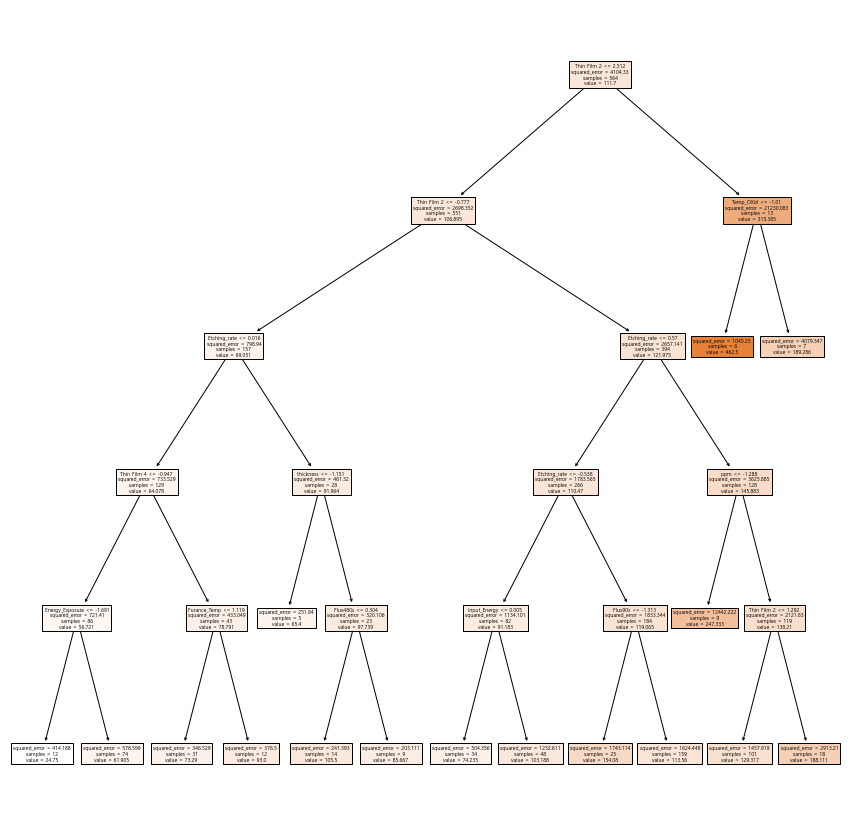

In [99]:
plt.figure(figsize=[15,15])
plot_tree(best_model['decisiontreeregressor'], filled=True,
          feature_names=X.columns.tolist())
plt.savefig('tree_result.pdf')
plt.show()

# Mission

- 아래의 사례들의 대해 어떤 가설 검정 기법을 써야하는지 작성하시오.  
- Ex. 10대와 20대의 주당방문횟수(정규성X)의 평균의 차이가 있는지 확인해야하는 상황 
      -> stats.ranksums( ) 
1. '방송구분'이라는 항목에서 '녹화방송'과 '재방송' 두 집단의 정규성을 띄지 않는 '상품주문수량'의 평균의 차이가 있는지 확인해야 하는 상황 
2.  비정규 분포를 따르는 '판매단가'와 '수수료율'의 상관성을 확인해야 하는 상황 
    - 판매단가 - 연속형 / 수수료율 - 연속형 
    - 연속형 비정규 -> stats.spearmanr( ) 
3. '배송방식'과 '매입형태' 간의 연관성이 있는지 확인해야 하는 상황 
4. 정규분포를 따르며, 분산이 서로같은 '고객연령'에 대해, 고객의 주소지(3개이상) 별 연령의 평균의 차이가 있는지 확인해야하는 상황 
    - stats.f_oneway() 
5. 정규분포를 따르며, 분산이 서로 다른 '프로그램' 3 종류에 따라 '매출액의 평균이 다른지 확인해야하는 상황 

- df1 데이터를 이용하여 아래의 문제를 해결 (~ 5번) 
1. 데이터 구조와 타입을 확인하고, 각 항목 별 결측값의 개수를 확인하시오.
2. '방송구분'에서 '녹화방송'에 해당하는 데이터만 뽑아서, '상품목표주문금액'의 평균과 중앙값의 차이를 계산하시오.

7. '방송소요시간'이 가장 오래걸린 상위 10개의 광고 품목을 확인 

9. '방송구분'에서 '생방송'과 '녹화방송'의 매출의 차이를 비교하고자한다. 
    - '영업이익'의 정규성을 확인 
    - '생방송'과 '녹화방송' 집단의 '영업이익'의 평균의 차이가 있는지 가설검정 수행 
13. '매입형태'와 '매입과세구분'의 연관성이 있는지 가설검정을 수행 

In [101]:
df1 = pd.read_csv('12_Data.csv')

In [108]:
# 2. '방송구분'에서 '녹화방송'에 해당하는 데이터만 뽑아서, 
#    '상품목표주문금액'의 평균과 중앙값의 차이를 계산하시오.
cond1 = (df1['방송구분']=='녹화방송')
df1.loc[cond1]['상품목표주문금액'].mean() - df1.loc[cond1]['상품목표주문금액'].median()

10473921.794871796

In [110]:
# 3. '상품주문금액'과 '상품목표주문금액'의 차이를 계산하여, '영업이익' 항목을 생성
df1['영업이익']= df1['상품주문금액']-df1['상품목표주문금액']

In [113]:
# 4. '방송시작시간' 데이터로 부터, '연도'/'월'/'요일' 생성
df1['방송시작일자_dt'] = pd.to_datetime(df1['방송시작시간'])
df1['연도'] = df1['방송시작일자_dt'].dt.year
df1['월'] = df1['방송시작일자_dt'].dt.month
df1['요일'] = df1['방송시작일자_dt'].dt.day_name()

In [118]:
# 5. '방송구분'에 따른 '연도' 별 '영업이익'의 증감율을 계산 
p1 = df1.pivot_table(index='방송구분',columns='연도',values='영업이익', aggfunc='sum')
p1['증감율'] = (p1[2021] - p1[2020]) / p1[2020]
p1

연도,2020,2021,증감율
방송구분,,,
녹화방송,-1.894549e+08,NaN,NaN
생방송,-3.573885e+10,-8.152800e+10,1.281215
재방송,-1.511756e+10,-1.906222e+10,0.260932


In [123]:
# 6. '방송시작시간'과 '방송종료시간'의 차이를 계산하여, '방송소요시간'항목을 생성 
df1['방송종료일자_dt'] = pd.to_datetime(df1['방송종료시간'])

In [126]:
df1['방송소요시간'] = df1['방송종료일자_dt'] - df1['방송시작일자_dt']
df1['방송소요시간'].describe()

count                        26283
mean     0 days 01:00:28.113229083
std      0 days 00:13:38.395746483
min                0 days 00:10:00
25%                0 days 01:00:00
50%                0 days 01:00:00
75%                0 days 01:05:00
max                1 days 01:05:00
Name: 방송소요시간, dtype: object

In [137]:
# 8. '프로그램명'항목에서 빈도수가 1000건 이상인 데이터만 추출하여, 
#     '방송구분' 별 '상품주문금액'과 '영업이익'의 합을 계산 
df_count = pd.DataFrame(df1['프로그램명'].value_counts())
cond1 = (df_count['프로그램명']>=1000)
list_1000 = df_count.loc[cond1].index.tolist()

cond1 = df1['프로그램명'].isin(list_1000)
df1.loc[cond1].pivot_table(index='방송구분', values=['상품주문금액','영업이익'],
                          aggfunc='sum')

,상품주문금액,영업이익
방송구분,,
생방송,490453552166,-38166117445
재방송,346480899,10929779


In [139]:
# 10. '방송구분'에서 '녹화방송'에 해당하는 데이터만 추출하여, '영업이익'항목에 대해 
#      RobustScaling을 수행하고, 스케일링 된 '영업이익'의 최댓값을 계산 
cond1 = (df1['방송구분']=='녹화방송')
df_scale = df1.loc[cond1]

In [140]:
from sklearn.preprocessing import RobustScaler

In [146]:
scaler = RobustScaler()
scaler.fit( df_scale[['영업이익']] )
pd.DataFrame(scaler.fit_transform(df_scale[['영업이익']]))[0].max()

2.897498227936112

In [148]:
# 11. '영업이익'이 양수이면 1 / 음수이면 0 으로 변환하여 'Target' 항목으로 생성
# 12. '소요분'/'상품방송순번' / '판매단가' / '수수료율' / 'ARS금액'을 입력했을 때,
#      'Target'을 분류하는 분류 모델을 생성 
cond1 = (df1['영업이익'] >= 0 )
df1.loc[cond1, 'Target']  = 1 
df1.loc[~cond1, 'Target'] = 0  # ~ not 

In [152]:
X = df1[['소요분','상품방송순번','판매단가','수수료율', 'ARS금액']]
Y = df1['Target']

In [153]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from sklearn.impute    import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree       import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [154]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [160]:
model_pipe = make_pipeline(KNNImputer(), StandardScaler(),DecisionTreeClassifier())

hyperparameter_list = {'decisiontreeclassifier__max_depth':range(5,11),
                      'decisiontreeclassifier__min_samples_split':range(5,11),
                      'decisiontreeclassifier__min_samples_leaf':range(5,11)}

grid_model = GridSearchCV(model_pipe, cv=5, param_grid=hyperparameter_list, 
                          scoring='f1',n_jobs=-1)
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': range(5, 11),
                         'decisiontreeclassifier__min_samples_leaf': range(5, 11),
                         'decisiontreeclassifier__min_samples_split': range(5, 11)},
             scoring='f1')

In [161]:
best_model = grid_model.best_estimator_

In [162]:
# 평가 
from sklearn.metrics import classification_report

In [163]:
def evaluation_func_class(best_model):
    Y_train_pred = best_model.predict(X_train)
    Y_test_pred  = best_model.predict(X_test)
    print('학습능력평가')
    print(classification_report(Y_train, Y_train_pred))
    print('일반화능력평가')
    print(classification_report(Y_test, Y_test_pred))

In [164]:
evaluation_func_class(best_model)

학습능력평가
              precision    recall  f1-score   support

         0.0       0.69      0.87      0.77     12204
         1.0       0.63      0.35      0.45      7508

    accuracy                           0.68     19712
   macro avg       0.66      0.61      0.61     19712
weighted avg       0.67      0.68      0.65     19712

일반화능력평가
              precision    recall  f1-score   support

         0.0       0.69      0.86      0.77      4129
         1.0       0.59      0.33      0.43      2442

    accuracy                           0.67      6571
   macro avg       0.64      0.60      0.60      6571
weighted avg       0.65      0.67      0.64      6571

